<a href="https://colab.research.google.com/github/cfong32/data6100-final-proj/blob/master/data6100_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span>1</span>. Executive Summary

In this notebook, we are going to build a machine learning model to estimate the *New York City Taxi Fare* based on the pickup date-time and coordinates, dropoff coordinates and number of passengers.  This was a task of a competition organized by Kaggle in partnership with Google Cloud and Coursera linked [here](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview). In order to estimate the fare accurately, the following steps were considered.

* The train and test data provided by Kaggle were imported, cleaned and preapred for runing the model.
* **Large data:**  More than 55,000,000 rows of data was too much for us to import and process on Google Colab.  The data had to be imported chunk by chunk, and we only sampled 10% of data to use, which were 5M rows.
* **Distances:**  Latitudes and longitudes of pickup and dropoff locations were transformed into distances.  This happened to be one of the most important variables for our models.
* **Neighbourhood:** Another important proxy of the latitude and longitude is neighbourhood. We used K-means algorithm to calculate the neighbourhood, whereas DBSCAN did not work under the limited resources we have in Colab.
* **Outliers in train set:** Outliers in the train set were removed based on the test set ranges.
* **Linear Model to estimate the major component:** Based only on distance calculated, we fitted a linear model to predict the fare. A linear relationship between distance and fare was detected. This was confirmed by our fare versus distance plot, and also the residual plot.
* **Gradient Boosting methods to estimate the residual**:
    * **Gradient Boosting Regression (GBR):** A small Gradient Boosting Tree model was built based on a subset of data (50,000 rows).  This initial model helped guide us in hyperparameter searching and model interpretation.
    * **Histogram Gradient Boosting Regression (HGBR):** We used this model for final submission as we could load more data and process it with current resources.

* **Time features:** Year, month, day-of-week and hour were included as time features.  Year was found having the most impact on fare, which is reasonable due to inflations year by year.  Different hours, especially during the rush hours of the city, were also found to have different fare distributions.

* **Feature importances:** Based on the importance analysis of our Gradient Boosting models, apart from latitude and longitude, distance and year had played the most important roles in the fare estimation.

* **Cross-validation:** 5-fold cross validation was employed to evaluate the performances of our Linear Regression and Histogram-based Gradient Boosting Regression models.

* **Two-stage modeling approach:** By adding a second stage model (Gradient Boosting) to compensate for errors of the Linear Model, improvements in terms of root-mean-square-error (RMSE) and in the distribution of the residual were observed.

Finally, We have achieved a RMSE score of **3.32** on the evaluation set kept by Kaggle.


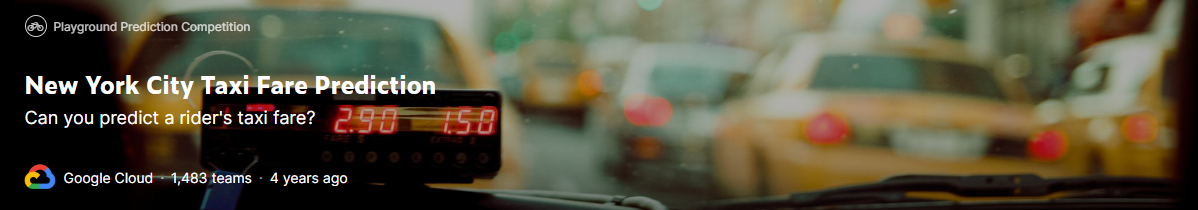

## 1.1 Kaggle Scores

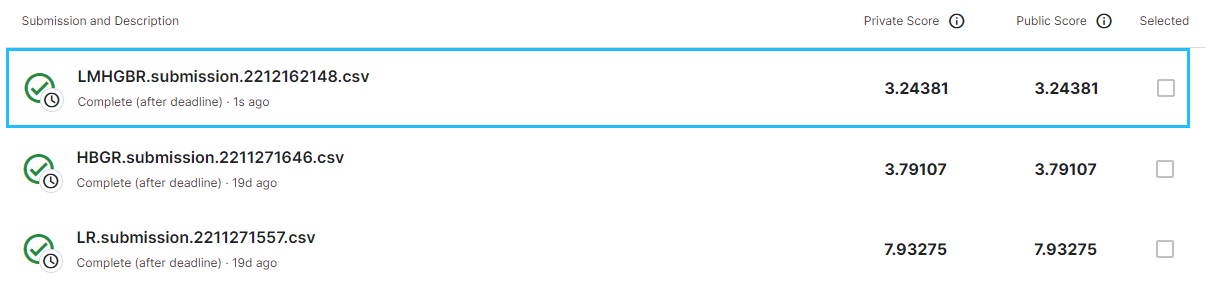

- **LMHGBR.submission.2212162148.csv** --- scored **3.24381**
    - Our final approach
    - A two-stage model (**Linear Model** + **Histogram-based Gradient Boosting Regression Trees**)
    - Features used: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `passenger_count`, `year`, `month`, `weekday`, `hour`, `dist`
- **HBGR.submission.2211271646.csv**  --- scored **3.79107**
    - A **Histogram-based Gradient Boosting Regression Trees**
    - Features used: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `passenger_count`, `year`, `month`, `day`, `weekday`, `hour`, `minute`
- **LR.submission.2212271557.csv**  --- scored **7.93275**
    - A Baseline **Linear Regression Model**
    - Features used: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `passenger_count`, `year`, `month`, `day`, `weekday`, `hour`, `minute`

# <span>2</span>. Ethics

The release of this compeition and dataset may have caused some ethical issues as follows:

1. Although releasing the fare prices could increase transparency and fairness, it can cause problems such as:
  - Passengers or drivers may compare the prices regardless of time and location.  They may expect the similar fare amounts for the similar trips.  Yet in fact conditions and total fares could change over time.
  - Drivers tend to go to the places with higher prices recorded. Not only it may cause a traffic issue in certain areas and make the life of residents in this area difficult, it could also result in difficulties in finding a taxi in cheaper areas.

2. If the estimation is not correct, drivers may be forced to receive less or more than what they should. The same could be true for customers.

3. Because of exact time of arrival and departure privacy of people could be jeopardized. For example, if you know your friend works in Uber and he is in the specific location at certain time, you could understand where he goes afterwards or before.

4. It could bring some security issues. For example, criminals could find routes with less traffic for escaping. Or if they know someone takes taxi regularly they could find the origin and destination and do some criminal acts.

# <span>3</span>. Exploratory Data Analysis

In [1]:
# Download dataset

!wget -q --show-progress -O new-york-city-taxi-fare-prediction.zip https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESnzvg-NHEhPgoURZmVYv1MBUS3GVlHGGUTbnBRS10J3Eg?download=1
!unzip -o new-york-city-taxi-fare-prediction.zip

# Download cached train dataframe (optional)
!wget -q --show-progress -O train.55M.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESkEabL3Tg9AjxTXVueJAvEBh9SkkH6pKiXBbsf_M46wmw?download=1

new-york-city-taxi- 100%[===================>]   1.56G  76.0MB/s    in 22s     
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
train.55M.dfpkl     100%[===================>]   4.13G  72.9MB/s    in 62s     


In [1]:
# Import libraries

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pytz
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from datetime import datetime, timezone
from tqdm import tqdm

pd.set_option('display.min_rows', 4)

## 3.1 Read Data and Augment Columns

We load and concatenate both **train** and **test** data in one dataframe so that we transform them together.  We also added some useful columns as listed in the following table.

Original          | Ours              | Description
---               | ---               | ---
fare_amount       | fare_amount       | target variable
pickup_datetime   | pickup_datetime   |
pickup_longitude  | pickup_longitude  |
pickup_latitude   | pickup_latitude   |
dropoff_longitude | dropoff_longitude |
dropoff_latitude  | dropoff_latitude  |
passenger_count   | passenger_count   |
                  | dataset           | indicating `'train'` or `'test'`
                  | year              | 2009-2015
                  | month             | 1-12
                  | weekday           | 0-6 incdicating Sun to Sat
                  | hour              | 0-23
                  | dist              | distance (km) between pickup and dropoff

In [2]:
# Helper functions

# Calculate distance between pickup and dropoff locations
def compute_dist(df):
    # source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    lat1 = df.pickup_latitude.map(np.deg2rad).values
    lon1 = df.pickup_longitude.map(np.deg2rad).values
    lat2 = df.dropoff_latitude.map(np.deg2rad).values
    lon2 = df.dropoff_longitude.map(np.deg2rad).values

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6373.0
    df['dist'] = R * c
    return df

# Load training data
def load_train_csv():
    if os.path.exists('train.55M.dfpkl'):
        df_train = pd.read_pickle('train.55M.dfpkl')
        print('data loaded from cache (train.55M.dfpkl)')
        return df_train
    else:
        chunks = pd.read_csv('train.csv',
                            nrows=None,
                            chunksize=1_000_000,
                            usecols=['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
                            engine='c',
                            )
        df_train = pd.concat([
            (chunk
            .assign(year   =lambda x: x.pickup_datetime.str[0:4].astype(int),
                    month  =lambda x: x.pickup_datetime.str[5:7].astype(int),
                    weekday=lambda x: pd.to_datetime(x.pickup_datetime.str[:10]).dt.weekday,
                    hour   =lambda x: x.pickup_datetime.str[11:13].astype(int),
                    )
            .drop(columns='pickup_datetime')
            )
            for chunk in tqdm(chunks)
        ])

        df_train.to_pickle('train.55M.dfpkl')
        print('data loaded from train.csv, also cached to train.55M.dfpkl')
        return df_train

# Load test data
def load_test_csv():
    df_test = (pd.read_csv('test.csv')
               .assign(year   =lambda x: x.pickup_datetime.str[0:4].astype(int),
                       month  =lambda x: x.pickup_datetime.str[5:7].astype(int),
                       weekday=lambda x: pd.to_datetime(x.pickup_datetime.str[:10]).dt.weekday,
                       hour   =lambda x: x.pickup_datetime.str[11:13].astype(int),
                       )
               .drop(columns='pickup_datetime')
               )
    print('data loaded from test.csv')
    return df_test

In [3]:
# Read dataset (train + test)

df = (
    pd.concat([
        (load_train_csv()
         .sample(frac=0.1, random_state=0)
         .assign(dataset='train')),
        (load_test_csv()
         .assign(dataset='test')),
    ])
    .pipe(compute_dist)
)

print('Number of samples')
print(f'train: {(df.dataset=="train").sum()}')
print(f'test : {(df.dataset=="test").sum()}')
display(df)

data loaded from cache (train.55M.dfpkl)
data loaded from test.csv
Number of samples
train: 5542386
test : 9914


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
27853670          8.9        -73.983130        40.761970         -73.994386   
21980810         30.5        -73.948505        40.753977         -73.808195   
...               ...               ...              ...                ...   
9912              NaN        -73.985573        40.735432         -73.939178   
9913              NaN        -73.988022        40.754070         -74.000282   

          dropoff_latitude  passenger_count  year  month  weekday  hour  \
27853670         40.749236                1  2010     10        4    21   
21980810         40.731952                2  2013     10        6     1   
...                    ...              ...   ...    ...      ...   ...   
9912             40.801731                6  2015      1        5     1   
9913             40.759220                6  2015      1        6    14   

         dataset                          key       dist  
27853670   train                          NaN   1.704594  
21980810   train                          NaN  12.075427  
...          ...                          ...        ...  
9912        test  2015-01-31 01:05:19.0000005   8.346106  
9913        test  2015-01-18 14:06:23.0000006   1.181196  

[5552300 rows x 13 columns]

## 3.2 Remove Out-of-range Training Data

**Observation**

🚩 By summarizing the data per train and test dataset as below, we realize that some observations in training data are **out of range** i.e. its `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count` are outside the range of the test data.  Also, some `fare_amount` happened to be negative, which is abnormal.  **We will DROP these out-of-range data points.**

In [4]:
# Simple description of train and test data

df.groupby('dataset').describe().stack()

fare_amount  pickup_longitude  pickup_latitude  \
dataset                                                          
test    count  0.000000e+00      9.914000e+03     9.914000e+03   
        mean            NaN     -7.397472e+01     4.075104e+01   
        std             NaN      4.277395e-02     3.354146e-02   
        min             NaN     -7.425219e+01     4.057314e+01   
        25%             NaN     -7.399250e+01     4.073613e+01   
        50%             NaN     -7.398233e+01     4.075305e+01   
        75%             NaN     -7.396801e+01     4.076711e+01   
        max             NaN     -7.298653e+01     4.170956e+01   
train   count  5.542386e+06      5.542386e+06     5.542386e+06   
        mean   1.134151e+01     -7.250755e+01     3.992044e+01   
        std    9.813108e+00      1.265296e+01     1.024438e+01   
        min   -1.450000e+02     -3.426609e+03    -3.488080e+03   
        25%    6.000000e+00     -7.399207e+01     4.073490e+01   
        50%    8.500000e+00     -7.398179e+01     4.075264e+01   
        75%    1.250000e+01     -7.396707e+01     4.076710e+01   
        max    1.021300e+03      3.442185e+03     3.378013e+03   

               dropoff_longitude  dropoff_latitude  passenger_count  \
dataset                                                               
test    count       9.914000e+03      9.914000e+03     9.914000e+03   
        mean       -7.397366e+01      4.075174e+01     1.671273e+00   
        std         3.907184e-02      3.543521e-02     1.278747e+00   
        min        -7.426324e+01      4.056897e+01     1.000000e+00   
        25%        -7.399125e+01      4.073525e+01     1.000000e+00   
        50%        -7.398002e+01      4.075406e+01     1.000000e+00   
        75%        -7.396406e+01      4.076876e+01     2.000000e+00   
        max        -7.299096e+01      4.169668e+01     6.000000e+00   
train   count       5.542353e+06      5.542353e+06     5.542386e+06   
        mean       -7.251171e+01      3.992378e+01     1.686930e+00   
        std         1.275337e+01      1.033346e+01     1.330843e+00   
        min        -3.408430e+03     -3.488080e+03     0.000000e+00   
        25%        -7.399142e+01      4.073400e+01     1.000000e+00   
        50%        -7.398018e+01      4.075311e+01     1.000000e+00   
        75%        -7.396369e+01      4.076808e+01     2.000000e+00   
        max         3.442185e+03      3.400392e+03     2.080000e+02   

                       year         month       weekday          hour  \
dataset                                                                 
test    count  9.914000e+03  9.914000e+03  9.914000e+03  9.914000e+03   
        mean   2.011816e+03  6.857979e+00  2.852834e+00  1.346742e+01   
        std    1.803347e+00  3.353272e+00  1.994451e+00  6.868584e+00   
        min    2.009000e+03  1.000000e+00  0.000000e+00  0.000000e+00   
        25%    2.010000e+03  4.000000e+00  1.000000e+00  8.000000e+00   
        50%    2.012000e+03  7.000000e+00  3.000000e+00  1.500000e+01   
        75%    2.014000e+03  1.000000e+01  5.000000e+00  1.900000e+01   
        max    2.015000e+03  1.200000e+01  6.000000e+00  2.300000e+01   
train   count  5.542386e+06  5.542386e+06  5.542386e+06  5.542386e+06   
        mean   2.011740e+03  6.265229e+00  3.041269e+00  1.351085e+01   
        std    1.860251e+00  3.436270e+00  1.949565e+00  6.517718e+00   
        min    2.009000e+03  1.000000e+00  0.000000e+00  0.000000e+00   
        25%    2.010000e+03  3.000000e+00  1.000000e+00  9.000000e+00   
        50%    2.012000e+03  6.000000e+00  3.000000e+00  1.400000e+01   
        75%    2.013000e+03  9.000000e+00  5.000000e+00  1.900000e+01   
        max    2.015000e+03  1.200000e+01  6.000000e+00  2.300000e+01   

                       dist  
dataset                      
test    count  9.914000e+03  
        mean   3.436449e+00  
        std    3.973621e+00  
        min    0.000000e+00  
        25%    1.298684e+00  
        50%    2.218108

In [5]:
# Remove out-of-range training records

def remove_out_of_range_records(df):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count']
    testset_max = df[testset][cols].max()    # max values in test set
    testset_min = df[testset][cols].min()    # min values in test set

    trainset_to_drop = (trainset
                        &
                        ((df[cols] > testset_max).any(axis=1)      # > max
                         | (df[cols] < testset_min).any(axis=1)    # < min
                         | (df['fare_amount'] < 0))                # -ve fare
                        )
    trainset_to_keep = trainset & ~trainset_to_drop

    return df[trainset_to_keep | testset]

df = remove_out_of_range_records(df)

print('Number of samples remained')
print(f'train: {(df.dataset=="train").sum()}')
print(f'test : {(df.dataset=="test").sum()}')

Number of samples remained
train: 5404392
test : 9914


## 3.3 Cluster Pickup and Dropoff Locations

Since latitude and longitude are not meaningful to the models. We previously calculate a distance proxy for pick up and drop off. In addition, we tried to do a clustering the neighbourhood by K means and DBSCAN. Generally, the latter one was recommended to do clustering on latitude and longitude however due to limited resources avaialable we were not able to get the good result with that as it either take too much time or run out of RAM for the process. Using simpler DBSCAN only gave 6 clusters with 200 data in each cluster on average with many outliers. In the end, when we say the plot of clusters, they do not seem meaningful. 

Having said that, we decided to use K means to do the clustering and it works somehow good. However, as we have pick up and drop off clusters and each have 50 clusters, it results in 100 more columns in the dataframe to be used in the model which is impossible to handle with the current colab resources.

In [6]:
# Train a K-means model to cluster pickup and dropoff locations

N = 100_000    # num of sample to use to fit the K-means model
K = 10         # num of clusters

sampled_coords = np.concatenate([
    df.sample(N//2)[['pickup_latitude', 'pickup_longitude']].values,
    df.sample(N//2)[['dropoff_latitude', 'dropoff_longitude']].values
])

kmeans = KMeans(K, random_state=0).fit(sampled_coords)
labels = kmeans.labels_

print('number of clusters: ', K)

number of clusters:  10


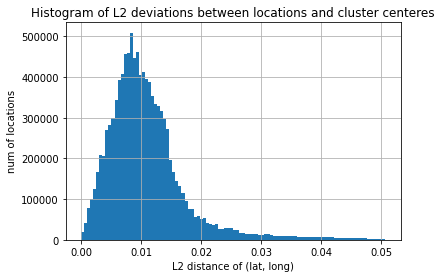

In [7]:
# Compute the cluster labels

coords = np.concatenate([
    df[['pickup_latitude', 'pickup_longitude']].values,
    df[['dropoff_latitude', 'dropoff_longitude']].values
])
labels = kmeans.predict(coords)
centers = kmeans.cluster_centers_[labels]


# For locations which are too far (> 99-th percentile) from the cluster centers
# asssign them to a new seperate group

deviations = ((coords - centers)**2).sum(axis=1)**0.5    # L2 distance between the locations and their clustered centers
dev_99_pct = np.quantile(deviations, 0.99)               # 99-th percentile
closely_clustered = deviations < dev_99_pct
labels = np.where(closely_clustered, labels, K)
df['pickup_cluster']  = labels[:len(labels)//2]
df['dropoff_cluster'] = labels[len(labels)//2:]


# Histogram of deviations

pd.Series(deviations[deviations < dev_99_pct]).hist(bins=100)
plt.title('Histogram of L2 deviations between locations and cluster centeres')
plt.ylabel('num of locations')
plt.xlabel('L2 distance of (lat, long)')
plt.show()

In [8]:
num_point_to_plot = 10000

colors = ['#'+str(hex(round(np.random.rand()*1e9)))[-6:] for _ in range(K+1)]

map = folium.Map(location=coords.mean(axis=0),
                 zoom_start=12,
                 )

idx = np.arange(len(coords))
np.random.choice(idx, num_point_to_plot)
for i, ((lat, lon), label) in enumerate(zip(coords[idx], labels[idx])):
    folium.CircleMarker(
        location=(lat, lon),
        radius=12,
        weight=2,
        fill=True,
        fill_color=colors[label],
        color=colors[label],
    ).add_to(map)
    if i >= num_point_to_plot:
        break
map

## 3.3 Check if `year`, `month`, `weekday` or `hour` Matters?

**Observation**

🚩 Both `year` and `hour` have a more significant influence on the fare (per km).

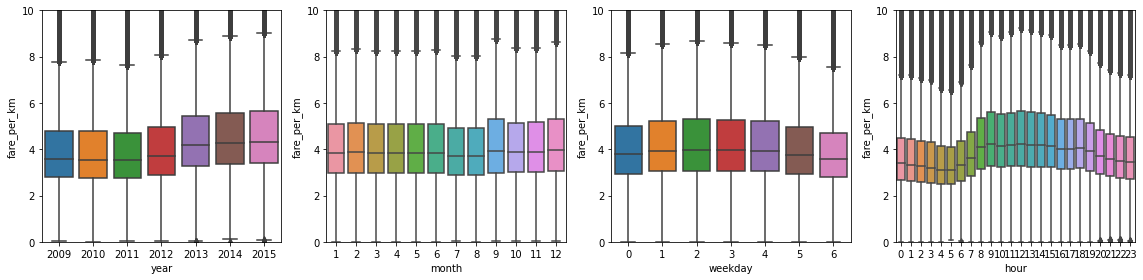

In [9]:
# Plot the fare_per_km vs time features

fig, axes = plt.subplots(1,4, figsize=(16,4))
for col, ax in zip(['year', 'month', 'weekday', 'hour'], axes.flat):
    sns.boxplot(
        data=df.assign(fare_per_km=lambda x: x.fare_amount/x.dist),
        x=col,
        y='fare_per_km',
        ax=ax,
    )
    ax.set_ylim(0,10)
plt.tight_layout()
plt.show()

## 3.4 Correlation Matrix

**Observation**

🚩 Out of all available features, `dist` correlates the most to our target variable `fare_amount`.

In [10]:
# Info of all columns

df[df.dataset=='train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5404392 entries, 27853670 to 31453306
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float64
 1   pickup_longitude   float64
 2   pickup_latitude    float64
 3   dropoff_longitude  float64
 4   dropoff_latitude   float64
 5   passenger_count    int64  
 6   year               int64  
 7   month              int64  
 8   weekday            int64  
 9   hour               int64  
 10  dataset            object 
 11  key                object 
 12  dist               float64
 13  pickup_cluster     int32  
 14  dropoff_cluster    int32  
dtypes: float64(6), int32(2), int64(5), object(2)
memory usage: 618.5+ MB


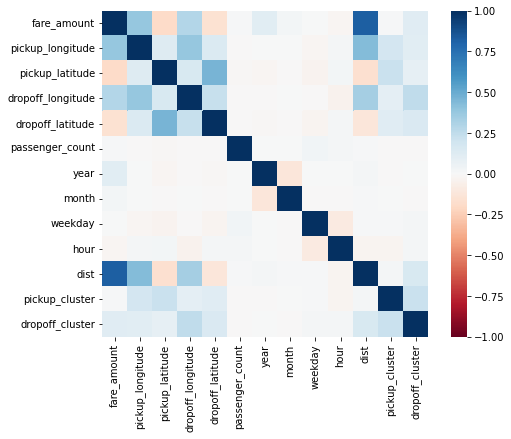

In [11]:
# Show correlations between columns

plt.figure(figsize=(8,6))
sns.heatmap(df[df.dataset=='train'].corr(), cmap='RdBu', vmin=-1, vmax=1)
plt.gca().set_aspect('equal')
plt.show()

# <span>4</span>. Modeling

We are trying to model the $fare$ by two parts:
1. Part of the $fare$ will be predicted by a linear model (LM) which takes only $dist$ as input.
2. Residual of this linear model will then be captured by other model (HGBR) which takes in all other features ($X$).

\begin{align*}
\hat{fare}
    &= LM(dist) + HGBR(X)
\\  &= \left(\beta~dist + \gamma \right)+ HGBR(X)
\end{align*}

## 4.1 Training the Linear Model (LM)

We first try to train a linear model which best predict the fare by only using distance traveled, i.e.
\begin{align*}
\hat{fare}
    &= LM(dist)
\\  &= \beta~dist + \gamma
\end{align*}
where $\beta$ is the slope, and $\gamma$ is the intercept (or offset).

### 4.1.1 Data preprocessing

The preprocessing procedure is as follows,

1. Divide the dataframe to train and test datasets.
2. Remove existing outliers in train data based on the test data ranges.  This is done in previous sections.  Revomed data is %2.5 of the observations. 
3. Make sure there is no NA in the train dataset and the X and y have the same length before fitting the model.
4. Standardise the variables to treat all variables evenly.

In [12]:
# Helper function for standardizing X and y

def standardize_n_prepare_Xy(df, cols_X, col_y):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    # Make sure there is no NA
    assert df[trainset][cols_X].notna().all().all()
    assert df[trainset][col_y].notna().all().all()
    assert df[testset][cols_X].notna().all().all()
    
    # Standardize X_train and y_train
    sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
    X_train = ((df[trainset][cols_X] - sr_mean_X) / sr_std_X).values
    y_train = df[trainset][col_y].values

    # Standardize X_test
    X_test = ((df[testset][cols_X] - sr_mean_X) / sr_std_X).values

    return X_train, y_train, X_test, sr_mean_X, sr_std_X

In [13]:
# Input and output variables

cols_X = ['dist']
col_y = 'fare_amount'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df, cols_X, col_y)

X_train.shape, y_train.shape, X_test.shape

((5404392, 1), (5404392,), (9914, 1))

### 4.1.2 Training

In [14]:
# Evaluate performnace using CV

model = LinearRegression()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores (RMSE):', scores)
print('Mean cross-validation score (RMSE):', np.mean(scores))

5-fold cross-validation scores (RMSE): [5.50920221 5.54042996 5.56465779 5.47074503 5.47558373]
Mean cross-validation score (RMSE): 5.512123744332145


In [15]:
# Fit a model to predict

model.fit(X_train, y_train)
y_hat = model.predict(X_train)
y_residual = y_train - y_hat

beta = model.coef_[0]
gamma = model.intercept_
print(f'Model equation:')
print(f'fare_amount = dist * {beta} + {gamma}')

Model equation:
fare_amount = dist * 7.912460074028038 + 11.3201681063311


In [16]:
# Add results (as two columns) to our dataframe

# adding the prediction as 'lm_pred'
df.loc[df.dataset=='train', 'lm_pred']     = y_hat
df.loc[df.dataset=='test' , 'lm_pred']     = model.predict(X_test)

# adding the residual as 'lm_residual'
df.loc[df.dataset=='train', 'lm_residual'] = y_residual

### 4.1.3 Interpretation

Therefore,
\begin{align*}
\hat{fare} = 7.92 ~ dist + 11.32
\end{align*}

So, from the data the model has observed that,
- the fare should on average increase \\$ 7.92 per km,
- the starting fare is effectively \\$ 11.32.

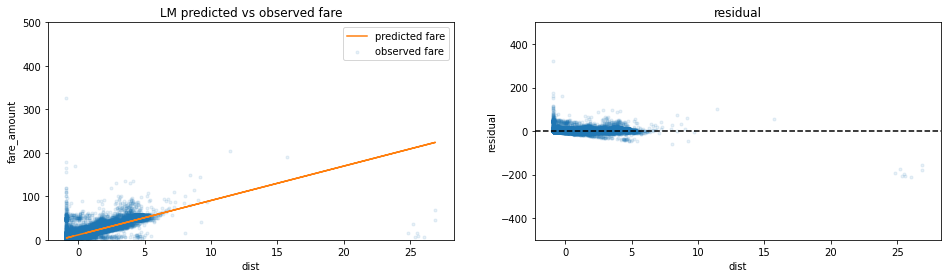

In [17]:
# Visualize performance of the linear model

num_point_to_plot = 100000

idx = np.arange(len(X_train)) 
np.random.shuffle(idx) 
idx = idx[:num_point_to_plot] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.scatter(X_train[idx], y_train[idx], label='observed fare', alpha=0.1, marker='.', color='C0')
ax1.plot(X_train[idx], y_hat[idx], label='predicted fare', color='C1')
ax1.set_title('LM predicted vs observed fare')
ax1.set_ylabel('fare_amount')
ax1.set_xlabel('dist')
ax1.legend()
ax1.set_ylim(0,500)

ax2.scatter(X_train[idx], y_residual[idx], label='data', alpha=0.1, marker='.', color='C0')
ax2.axhline(0, color='k', ls='--')
ax2.set_title('residual')
ax2.set_ylabel('residual')
ax2.set_xlabel('dist')
ax2.set_ylim(-500,500)

plt.show()

**Observation**

🚩 Both `year` and `hour` are still having a clear relationship with `lm_residual`, which we are going to predict next.

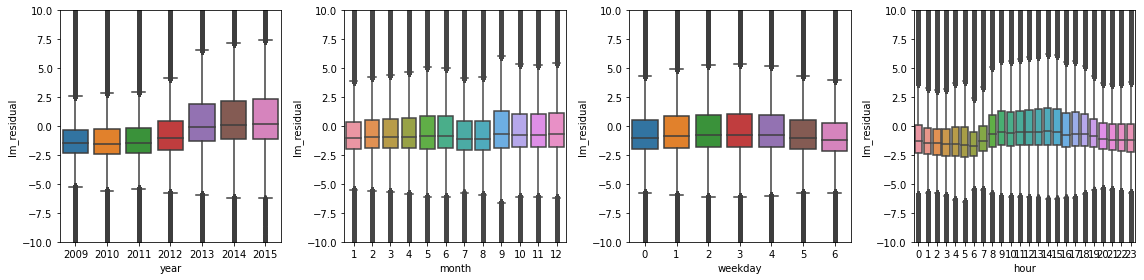

In [18]:
# Check if the residual varies with with different time features

fig, axes = plt.subplots(1,4, figsize=(16,4))
for col, ax in zip(['year', 'month', 'weekday', 'hour'], axes.flat):
    sns.boxplot(
        data=df.assign(residual_per_km=lambda x: x.lm_residual/x.dist),
        x=col,
        y='lm_residual',
        ax=ax,
    )
    ax.set_ylim(-10,10)
plt.tight_layout()
plt.show()

## 4.2 Training the Residual Model (HGBR)

Having done a Linear Regression on the distance previously, we first used **Histogram-based Gradient Boosting Regression Tree** to train the on the residuals to estimate the taxi fare. Next, in order to increase the interpretation we use **Gradient Boosting for Regression** to do the same. 

\begin{align*}
\hat{residual} = HGBR(X)
\end{align*}

where $X$ contains 10 following features:
- `pickup_latitude`,
- `pickup_longitude`,
- `dropoff_latitude`,
- `dropoff_longitude`,
- `passenger_count`,
- `year`,
- `month`,
- `weekday`
- `hour`
- `dist`

### 4.2.1 Training GBR

We tried using Gradient Boosting for Regression as it enabled us interpret the results better than Histogram-based Gradient Boosting Regression. However, as stated in the sklearn documentation we should use Histogram-based Gradient Boosting Regression rather than Gradient Boosting for Regression for data rows more than 10,000. We also tried using Gradient Boosting for Regression with 50,000 with simple hyperparameters but it took too much time with the resources avaialable in colab. Therefore, we ended up using Gradient Boosting for Regression for interpretation and Histogram-based Gradient Boosting Regression for full dataset for the submission.

In [19]:
# Input and output variables

cols_X = [
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
    'dist',
]
col_y = 'lm_residual'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df,
                                                          cols_X,
                                                          col_y)

print("Train set X values shape:\n", X_train.shape,
      "\nTrain set y value shape:\n", y_train.shape,
      "\nTest set X values shape:\n", X_test.shape)

Train set X values shape:
 (5404392, 10) 
Train set y value shape:
 (5404392,) 
Test set X values shape:
 (9914, 10)


#### Cross Validation for Hyperparameter Tuning

In order to obtain the best hyperparameters for the GBR, we used the following for loop to test a few important hyperparameters. Because of resource limitation, we were not able to run all combinations listed below together. Instead, we run the choose only 2 variables for each hyperparameters in each run and keep the best one for the next run.
- **n_estimators:** The number of sequential trees to be modeled.
- **max_depth:** The maximum depth of a tree.
- **learning_rate:** The learning rate is the shrinkage you do at every step you are making in the tree.

In [20]:
# Subsetting the data as Gradient Boosting is not efficient on more than 10000 rows

X_train_sub = X_train[0:50000,]
y_train_sub = y_train[0:50000,]

X_train_GBR, X_test_GBR, y_train_GBR, y_test_GBR = train_test_split(X_train_sub,
                                                        y_train_sub,
                                                        test_size=0.1,
                                                        random_state=13)

In [21]:
# Fitting GBR

params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train_GBR, y_train_GBR)

GradientBoostingRegressor(max_depth=6, n_estimators=500)

Here we can see the general behaviour in machine learning i.e. the loss function of the train set tends to overfit and decreases more and more. While the loss function of the test set reach the minmum around 20 iterations and then becomes almost flat.

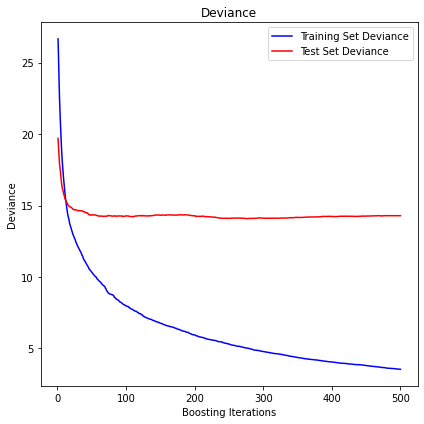

In [22]:
# Deviance plot

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test_GBR)):
    test_score[i] = mean_squared_error(y_test_GBR, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

We used this code to find the best hyperparameters of the Gradient Boosting for Regression. Ideally, we need to have more combination of variables to get a better results but we were only able to do this by using 3 hyperparameters with 2 value for each one. For example the following one took more than 1 hour to run.

In [23]:
# from sklearn.model_selection import GridSearchCV
# # due to lack of resources we run this several times to choose the best possbile combinations.
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [4, 6],
#     'learning_rate': [0.1, 1],
# }

# est = ensemble.GradientBoostingRegressor()

# gs_cv = GridSearchCV(est, param_grid, cv=5).fit(X_train_GBR, y_train_GBR)

# # best hyperparameter setting
# gs_cv.best_params_
#{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

As we were not able to add clusters to the model due to lack of resources we kept the longtitudes and latitudes of pickup and dropoff locations. The following plot shows the importance of variables detected by the model. Regardless of the longtitudes and latitudes of pickup and dropoff locations, we can see that distance and year are the most important variables on the fare which seem very reasonable.

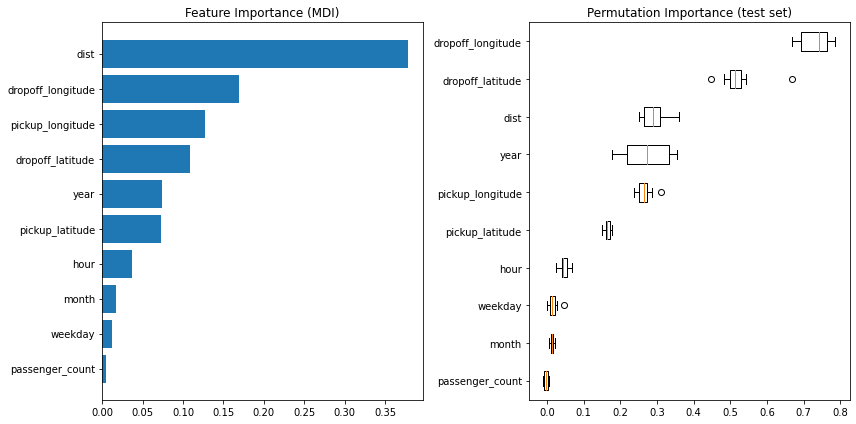

In [24]:
# Feature importance plots

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols_X)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test_GBR, y_test_GBR, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols_X)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### 4.2.2 Training HGBR

As we were able to run the Histogram-based Gradient Boosting Regression model on our full training set as below.

In [25]:
# Adding cluster information

df_cluster_dummies = (
    (df['pickup_cluster'].astype(str) + '|' +
     df['dropoff_cluster'].astype(str))
    .str.get_dummies()
    .add_prefix('cluster_')
    .astype('int32')
)

df = pd.concat([df, df_cluster_dummies], axis=1)

In [26]:
# Input and output variables

cols_X = [
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
    'dist',
    *[col for col in df.columns if 'cluster_' in col],
]
col_y = 'lm_residual'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df,
                                                          cols_X,
                                                          col_y)

print("Train set X values shape:\n", X_train.shape,
      "\nTrain set y value shape:\n", y_train.shape,
      "\nTest set X values shape:\n", X_test.shape)

Train set X values shape:
 (5404392, 21) 
Train set y value shape:
 (5404392,) 
Test set X values shape:
 (9914, 21)


In [27]:
# Histogram-based Gradient Boosting Regression Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

# Evaluate performnace using CV

model = HistGradientBoostingRegressor()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores (RMSE):', scores)
print('Mean cross-validation score (RMSE):', np.mean(scores))

5-fold cross-validation scores (RMSE): [3.7874216  3.82565742 3.90650001 3.75824852 3.82117366]
Mean cross-validation score (RMSE): 3.819800242156351


In [28]:
# Fit a model to predict

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
y_hat = model.predict(X_train)


# Compute the overall prediction : 'overall_pred' = 'lm_pred' + 'res_pred'

df.loc[df.dataset=='train', 'res_pred'] = y_hat
df.loc[df.dataset=='test' , 'res_pred'] = model.predict(X_test)
df['overall_pred']     = df['lm_pred'] + df['res_pred']
df['overall_residual'] = df['fare_amount'] - + df['overall_pred']

In [29]:
# Evalulate the overall RMSE on the training set

df_train = df[df.dataset=='train']
true = df_train['fare_amount'].values
pred = df_train['overall_pred'].values
rmse = ((true-pred)**2).mean()**0.5

print(f'Overall RMSE: {rmse}')

Overall RMSE: 3.780609948583959


## 4.3 Comparing Residuals of Two Stages

**Observation**

🚩 The first Linear Model (**LM**) tends to over-estimate the fare.  It resulted in **a residual which biased to the negative side**.

🚩 The second Histogram-based Gradient Boosting Regression model (**HGBR**) is able to fix this problem.  It adjusted the **overall residual to a more balanced distibution**.

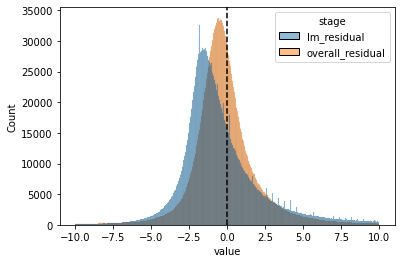

In [30]:
# Compare the distributions of residual of two stages

vmin, vmax = -10, 10
data = (df[['lm_residual', 'overall_residual']]
        .dropna()
        .rename_axis(columns='stage')
        .stack()
        .rename('value')
        .reset_index()
        .query(f'value>{vmin} and value<{vmax}')
)

sns.histplot(
    data=data,
    hue='stage',
    x='value',
)
plt.axvline(0, color='k', ls='--')
plt.show()

# <span>5</span>. Make a submission CSV

Finally, we create the CSV file based on sample submission file to submit in Kaggle.

In [31]:
import pytz
from datetime import datetime, timezone

# make submission csv
df_submission = pd.DataFrame({
    'key'        : df[df.dataset=='test']['key'],
    'fare_amount': df[df.dataset=='test']['overall_pred'],
})

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
save_path = f'LMHGBR.cluster.submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to LMHGBR.cluster.submission.2212162351.csv
